# 데이터 로딩
- 사용자-영화 평점 행렬 데이터
- Grouplens 사이트에서 만든 MovieLens 데이터 셋 사용 (축소버전 파일 사용)
- https://grouplens.org/datasets/movielens/latest/

In [9]:
import pandas as pd
import numpy as np

movies = pd.read_csv('dataset/movies.csv')
ratings = pd.read_csv('dataset/ratings.csv')

print(movies.shape, ratings.shape)

(9742, 3) (100836, 4)


In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# 데이터 전처리

## 평점 데이터가 행 단위(테이블 형식)데이터도 되어있어 사용자-아이템(영화)평점 행렬로 변환
- rating 데이터는 행이 사용자 열이 영화로 되어있어야 함
-  피벗테이블을 이용해서 자료 전환하기

In [12]:
ratings = ratings.drop('timestamp', axis=1)
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [8]:
ratings_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

print(ratings_matrix.shape)
ratings_matrix.head(3)

(610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,60,61,62,63,64,65,66,...,183635,183897,183911,183959,184015,184053,184245,184253,184257,184349,184471,184641,184721,184791,184931,184987,184997,185029,185031,185033,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 영화 아이디를 영화 제목으로 변환하여 ratings_matrix 생성
- NaN 값은 0으로 변경

In [17]:
rating_movies = pd.merge(ratings, movies)

ratings_matrix = rating_movies.pivot_table(index='userId', columns='title', values='rating')
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),127 Hours (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Ghosts (1960),13 Going on 30 (2004),13 Hours (2016),13 Sins (2014),13 Tzameti (2005),13th (2016),"13th Warrior, The (1999)",1408 (2007),1492: Conquest of Paradise (1992),15 Minutes (2001),16 Blocks (2006),17 Again (2009),1776 (1972),18 Again! (1988),187 (One Eight Seven) (1997),1900 (Novecento) (1976),1941 (1979),1969 (1988),...,Young People Fucking (a.k.a. YPF) (2007),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),"Young Victoria, The (2009)","Young and the Damned, The (Olvidados, Los) (1950)",Youngblood (1986),Your Friends and Neighbors (1998),Your Highness (2011),Your Name. (2016),Your Sister's Sister (2011),"Yours, Mine and Ours (1968)","Yours, Mine and Ours (2005)",Youth (2015),Youth Without Youth (2007),Youth in Revolt (2009),Youth of the Beast (Yaju no seishun) (1963),Z (1969),Zabriskie Point (1970),Zack and Miri Make a Porno (2008),Zapped! (1982),Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
#################################### 구분선 ######################################

# 영화와 영화들 간 유사도 산출
- cosine_similarity()를 이용하여 영화와 영화들 간의 평점기반 유사도를 산출하기 위해 ratings_matrix데이터를 영화를 행 기준으로 만들기 위해 전치를 시켜야 함

In [18]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

# 영화간 유사도
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

item_sim_df = pd.DataFrame(item_sim, index=ratings_matrix.columns, columns=ratings_matrix.columns)

print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),127 Hours (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Ghosts (1960),13 Going on 30 (2004),13 Hours (2016),13 Sins (2014),13 Tzameti (2005),13th (2016),"13th Warrior, The (1999)",1408 (2007),1492: Conquest of Paradise (1992),15 Minutes (2001),16 Blocks (2006),17 Again (2009),1776 (1972),18 Again! (1988),187 (One Eight Seven) (1997),1900 (Novecento) (1976),1941 (1979),1969 (1988),...,Young People Fucking (a.k.a. YPF) (2007),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),"Young Victoria, The (2009)","Young and the Damned, The (Olvidados, Los) (1950)",Youngblood (1986),Your Friends and Neighbors (1998),Your Highness (2011),Your Name. (2016),Your Sister's Sister (2011),"Yours, Mine and Ours (1968)","Yours, Mine and Ours (2005)",Youth (2015),Youth Without Youth (2007),Youth in Revolt (2009),Youth of the Beast (Yaju no seishun) (1963),Z (1969),Zabriskie Point (1970),Zack and Miri Make a Porno (2008),Zapped! (1982),Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.285169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.24012,0.613139,0.000000,0.0,0.44905,1.0,0.0,0.0,0.000000,0.238833,0.0,0.0,0.329293,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.251259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.210675,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65561,0.0,0.0,0.0,0.212814,0.919145,0.0,0.0,0.120996,0.0,0.0,0.0,0.149201,0.0,0.0,0.0,0.178042,0.0,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.715542,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150269,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.124109,0.0,0.0,0.0

- 영화 'Godfather, The (1972)'와 평점 유사도가 높은 상위 6개 영화 추출

In [25]:
item_sim_df['Inception (2010)'].sort_values(ascending=False)[:6]

## 나와는 상관없이 다른 사람의 평점을 가지고 유사도가 높은 걸 뽑아낸 것들임

title
Inception (2010)                 1.000000
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

# 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천
- ratings_matrix는 모든 사용자의 평점 기준으로 영화의 유사도를 생성한 데이터


## 개인화된 예측 평점 계산
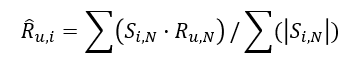
> 예측 평점 계산 수식 변수
>- Si,n : 아이템 i와 가장 유사도가 높은 Top-N개 아이템의 유사도 벡터
>- Ru,n : 사용자 u의 아이템 i와 가장 유사도가 높은 Top-N개 아이템에 대한 실제 평점 벡터

- 함수 매개변수
    - ratings_arr : 사용자 - 영화 평점 행렬, shape(610. 9719)
    - item_sim_arr : 영화간 평점 유사도 행렬, shape(9719, 9719)
    - n : Top-N 의 유사도를 가지는 영화의 수

In [28]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 예측 평점을 저장할 행렬 pred
    pred = np.zeros_like(ratings_arr)
    
    # ratings_arr.shape[1] >> 영화의 수만큼 반복
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 col번째 영화와 유사도가 높은 n개의 영화의 index를 반환
        ## 내림차순으로 다시 정렬 [::-1] 하고 [:n]개만큼 잘라내기
        top_n_items = np.argsort(item_sim_arr[:, col])[::-1][:n]
        
        # ratings_arr.shape[0] >> 사용자의 수만큼 반복
        for row in range(ratings_arr.shape[0]):
            # item_sim_arr[col, :][top_n_items] : col번째 영화와 유사도가 높은 Top-N개 영화의 유사도 벡터
            # ratings_arr[row,:][top_n_items] : row번째 사용자에 대해 col번째 영화와 유사도가 높은 Top-N개 영화에 대한 실제 평점 벡터 (실제평점 값이 없을 수 있음)
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row,:][top_n_items].T) / np.sum(np.abs(item_sim_arr[col,:][top_n_items]))
    
    return pred

In [30]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)

ratings_pred_matrix = pd.DataFrame(ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),127 Hours (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Ghosts (1960),13 Going on 30 (2004),13 Hours (2016),13 Sins (2014),13 Tzameti (2005),13th (2016),"13th Warrior, The (1999)",1408 (2007),1492: Conquest of Paradise (1992),15 Minutes (2001),16 Blocks (2006),17 Again (2009),1776 (1972),18 Again! (1988),187 (One Eight Seven) (1997),1900 (Novecento) (1976),1941 (1979),1969 (1988),...,Young People Fucking (a.k.a. YPF) (2007),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),"Young Victoria, The (2009)","Young and the Damned, The (Olvidados, Los) (1950)",Youngblood (1986),Your Friends and Neighbors (1998),Your Highness (2011),Your Name. (2016),Your Sister's Sister (2011),"Yours, Mine and Ours (1968)","Yours, Mine and Ours (2005)",Youth (2015),Youth Without Youth (2007),Youth in Revolt (2009),Youth of the Beast (Yaju no seishun) (1963),Z (1969),Zabriskie Point (1970),Zack and Miri Make a Porno (2008),Zapped! (1982),Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.372406,0.0,0.000000,0.0,0.0,1.424705,1.619797,0.0,0.140655,0.0,0.389949,0.0,0.0,0.000000,0.00000,0.389949,1.325574,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.988924,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.632580,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.00000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.220798,0.000000,0.000000,1.677291,0.284372
2,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.214767,0.000000,0.000000,

In [32]:
# 첫 번째 유저의 9719개의 영화에 대한 예측 평점 중 최댓값과 최솟값
print(np.max(ratings_pred_matrix, axis=1)[:1])
print(np.min(ratings_pred_matrix, axis=1)[:1])

userId
1    4.595776
dtype: float64
userId
1    0.0
dtype: float64


In [33]:
user_0 = ratings_pred_matrix.values[0]
print(len(user_0[user_0 != 0]))

1133


## 평점을 주지 않은 영화 목록 반환

In [36]:
# ratings_matrix : 유저-아이템 행렬(DataFrame)
def get_unseen_movies(ratings_matrix, userId):
    # 모든 영화에 대한 한 유저의 평점 다 가져옴
    user_rating = ratings_matrix.loc[userId,:]
    # 한 유저가 관람하지 않은(평점이 0인) 영화 리스트 가져오기
    unseen_list = user_rating[user_rating == 0].index.values
    return unseen_list

## 특정 사용자의 관람하지 않은 영화에 대한 예측 평점 기반 추천

In [39]:
def recomm_movie_by_userId(pred_df, userId, unseen_list, top_n=10):
    # 한 유저가 보지 않은 영화에 대해서 평점 유사도가 높은 영화
    recomm_movies = pred_df.loc[userId,unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [41]:
unseen_list = get_unseen_movies(ratings_matrix, 9)
recomm_movies = recomm_movie_by_userId(ratings_pred_matrix, 9, unseen_list, 10)


recomm_movies = pd.DataFrame(recomm_movies.values, index=recomm_movies.index, columns=['pred score'])
recomm_movies

,pred score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591
